<a href="https://colab.research.google.com/github/AaliyanShuja/SalesPrediction/blob/main/SalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries For the Project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from   scipy.stats import f_oneway
from   scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from   statsmodels.stats.outliers_influence import variance_inflation_factor
from   statsmodels.stats.multicomp import pairwise_tukeyhsd
import lightgbm as lgb
from   prophet import Prophet
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import mean_squared_error, r2_score
from   sklearn.preprocessing import StandardScaler, MinMaxScaler
from   sklearn.linear_model import LinearRegression
from   datetime import datetime
import dask.dataframe as dd



In [ ]:
!pip install "dask[dataframe]"

In [ ]:
df = pd.read_csv('/content/Women_Ecommerce_Purchase_Data.csv')
df.head()

,order_id,order_date,sku,color,size,unit_price,quantity,revenue,age,discount,customer_rating,stock,category,category_id,category_avg_price,category_total_revenue,category_popularity,holiday_type
0,185,2022-08-11 21:03:00,799,Dark Blue,L,266,7,1862,59,20,3,276,Jeans,2,274,559255,83,No Holiday
1,13,2022-08-05 12:18:00,799,Dark Blue,L,266,7,1862,20,15,2,331,Jackets,1,273,633186,90,No Holiday
2,56,2022-09-12 20:19:00,799,Dark Blue,XL,275,10,2750,47,5,2,144,Dresses,0,273,563441,84,No Holiday
3,5,2022-06-11 14:46:00,799,Dark Blue,XL,264,7,1848,59,0,2,126,Jackets,1,273,633186,90,No Holiday
4,27,2022-08-08 19:18:00,799,Dark Blue,M,266,4,1064,63,0,3,496,Jeans,2,274,559255,83,No Holiday


In [ ]:
df.describe()

,order_id,sku,unit_price,quantity,revenue,age,discount,customer_rating,stock,category_id,category_avg_price,category_total_revenue,category_popularity
count,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.000000,1266.00000,1266.000000,1266.000000,1266.000000,1266.000000
mean,115.556872,775.584518,278.892575,5.495261,1533.230648,40.763823,10.327804,2.921801,268.85861,2.434439,274.819115,607934.535545,87.516588
std,73.339346,42.376269,11.487659,2.889051,810.180335,13.665061,6.897841,1.351696,131.60860,1.891328,1.852587,61230.244307,7.103423
min,1.000000,628.000000,264.000000,1.000000,264.000000,18.000000,0.000000,1.000000,50.00000,0.000000,273.000000,553327.000000,79.000000
25%,53.000000,708.000000,266.000000,3.000000,834.000000,28.000000,5.000000,2.000000,149.00000,1.000000,273.000000,559255.000000,83.000000
50%,105.000000,799.000000,278.000000,6.000000,1584.000000,40.000000,10.000000,3.000000,265.00000,2.000000,274.000000,563441.000000,84.000000
75%,166.000000,799.000000,288.000000,8.000000,2224.000000,53.000000,15.000000,4.000000,381.00000,4.000000,277.000000,633186.000000,90.000000
max,273.000000,897.000000,298.000000,10.000000,2980.000000,64.000000,20.000000,5.000000,498.00000,5.000000,277.000000,707980.000000,99.000000


# Preprocessing


In [ ]:
# Checking the missing values
print("Missing values per column:\n", df.isnull().sum())

# Filling the missing numeric columns with their median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical columns with '3XL'
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('3XL')

Missing values per column:
 order_id                  0
order_date                0
sku                       0
color                     0
size                      0
unit_price                0
quantity                  0
revenue                   0
age                       0
discount                  0
customer_rating           0
stock                     0
category                  0
category_id               0
category_avg_price        0
category_total_revenue    0
category_popularity       0
holiday_type              0
dtype: int64


In [ ]:
# Removing the duplicates
df = df.drop_duplicates()
print(f"Shape after the duplicates removed is: {df.shape}")

Shape after the duplicates removed is: (1266, 18)


In [ ]:
# Defining the function to remove outliers based on IQR
def remove_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound  = Q1 - 1.5 * IQR
    upper_bound  = Q3 + 1.5 * IQR
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

# Apply the function to numeric columns
for col in numeric_cols:
    df = remove_outliers_iqr (df, col)

print(f"Shape after removing outliers: {df.shape}")


Shape after removing outliers: (1266, 18)


In [ ]:
cleaned_file_path = "/content/Women_Ecommerce_Purchase_Data.csv"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")

Cleaned data saved to /content/Women_Ecommerce_Purchase_Data.csv


In [ ]:
print(df.describe())

# Values for the categoruical columns
print(df['color'].value_counts())
print(df['size'].value_counts())

          order_id          sku   unit_price     quantity      revenue  \
count  1266.000000  1266.000000  1266.000000  1266.000000  1266.000000   
mean    115.556872   775.584518   278.892575     5.495261  1533.230648   
std      73.339346    42.376269    11.487659     2.889051   810.180335   
min       1.000000   628.000000   264.000000     1.000000   264.000000   
25%      53.000000   708.000000   266.000000     3.000000   834.000000   
50%     105.000000   799.000000   278.000000     6.000000  1584.000000   
75%     166.000000   799.000000   288.000000     8.000000  2224.000000   
max     273.000000   897.000000   298.000000    10.000000  2980.000000   

               age     discount  customer_rating       stock  category_id  \
count  1266.000000  1266.000000      1266.000000  1266.00000  1266.000000   
mean     40.763823    10.327804         2.921801   268.85861     2.434439   
std      13.665061     6.897841         1.351696   131.60860     1.891328   
min      18.000000     0.

# Trends and Pattern

In [ ]:
 # Converting the  order_date to datetime
df['order_date'] = pd.to_datetime(df['order_date'])

 # Extracting the time-based features
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day_of_week'] = df['order_date'].dt.dayofweek
df['day'] = df['order_date'].dt.day

print(df.head())

   order_id          order_date  sku      color size  unit_price  quantity  \
0       185 2022-08-11 21:03:00  799  Dark Blue    L         266         7   
1        13 2022-08-05 12:18:00  799  Dark Blue    L         266         7   
2        56 2022-09-12 20:19:00  799  Dark Blue   XL         275        10   
3         5 2022-06-11 14:46:00  799  Dark Blue   XL         264         7   
4        27 2022-08-08 19:18:00  799  Dark Blue    M         266         4   

   revenue  age  discount  ...  category  category_id category_avg_price  \
0     1862   59        20  ...     Jeans            2                274   
1     1862   20        15  ...   Jackets            1                273   
2     2750   47         5  ...   Dresses            0                273   
3     1848   59         0  ...   Jackets            1                273   
4     1064   63         0  ...     Jeans            2                274   

   category_total_revenue  category_popularity  holiday_type  year month  

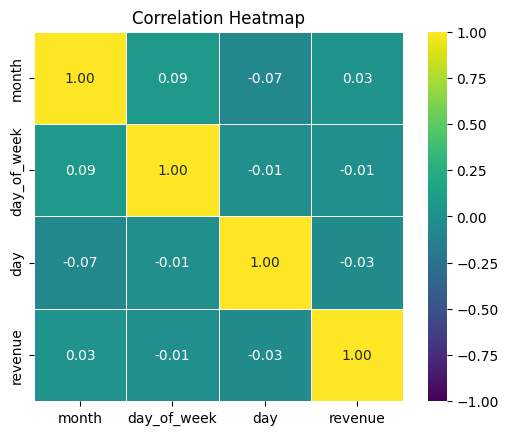

In [ ]:
correlation_matrix = df[['month', 'day_of_week','day', 'revenue']].corr()

#using heatmaps and finding correlation betweem different time with revenue
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
# Average revenue of month
monthly_revenue = df.groupby('month')['revenue'].mean()
print(monthly_revenue)

# Average revenue of week days
weekday_revenue = df.groupby('day_of_week')['revenue'].mean()
print(weekday_revenue)

# Average revenue of days
daily_revenue = df.groupby('day')['revenue'].mean()
print(daily_revenue)

month
6    1535.448598
7    1471.305147
8    1528.603933
9    1575.721698
Name: revenue, dtype: float64
day_of_week
0    1559.084577
1    1571.677019
2    1479.706587
3    1508.227941
4    1556.622407
5    1489.591743
6    1567.232394
Name: revenue, dtype: float64
day
1     1729.076923
2     1641.421053
3     1500.387097
4     1748.571429
5     1638.705882
6     1664.956522
7     1513.375000
8     1615.285714
9     1487.258824
10    1455.525424
11    1534.675000
12    1375.372093
13    1818.533333
14    1441.340909
15    1347.527273
16    1540.416667
17    1353.441860
18    1708.392857
19    1633.826087
20    1753.200000
21    1449.942857
22    1584.181818
23    1481.428571
24    1395.853659
25    1528.521739
26    1408.377358
27    1500.516129
28    1595.655172
29    1464.000000
30    1506.876712
31    1664.960000
Name: revenue, dtype: float64


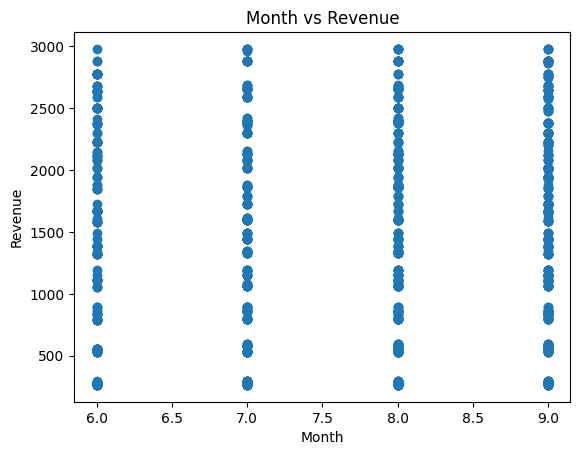

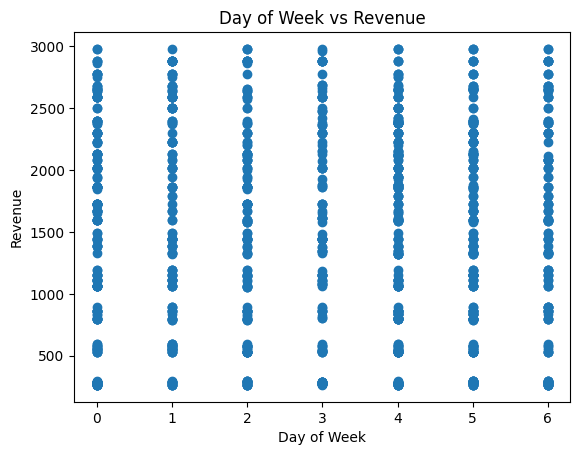

In [ ]:
# Scatter plot for month vs. revenue
plt.scatter(df['month'], df['revenue'])
plt.title('Month vs Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

# Scatter plot for day_of_week vs. revenue
plt.scatter(df['day_of_week'], df['revenue'])
plt.title('Day of Week vs Revenue')
plt.xlabel('Day of Week')
plt.ylabel('Revenue')
plt.show()

In [ ]:
# Add holiday flags (manually or using a calendar library)
df['is_holiday'] = df['order_date'].isin(['2024-12-25', '2024-11-23'])

# Analyze correlation with holidays
holiday_revenue = df.groupby('is_holiday')['revenue'].mean()
print(holiday_revenue)

is_holiday
False    1533.230648
Name: revenue, dtype: float64


<ipython-input-186-54eaf9d3778a>:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['order_date'].isin(['2024-12-25', '2024-11-23'])


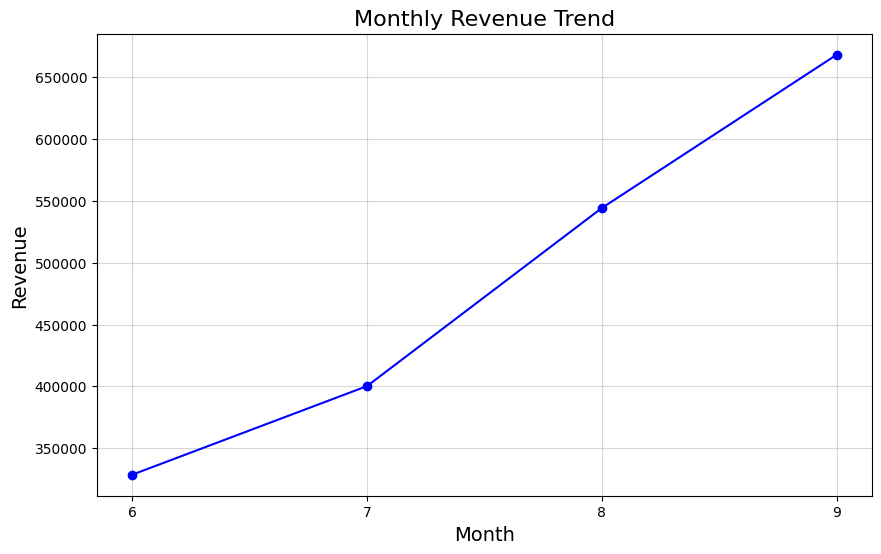

In [ ]:
# Extracting 'month' and 'revenue' for plotting
monthly_revenue = df.groupby('month')['revenue'].sum().reset_index()

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot ( monthly_revenue['month'],  monthly_revenue['revenue'], marker='o', linestyle='-', color='blue')
plt.title ('Monthly Revenue Trend', fontsize=16)
plt.xlabel ('Month', fontsize=14)
plt.ylabel ('Revenue', fontsize=14)
plt.xticks ( monthly_revenue['month'])  # Setting x-axis ticks to month values
plt.grid ( alpha=0.5 )
plt.show()

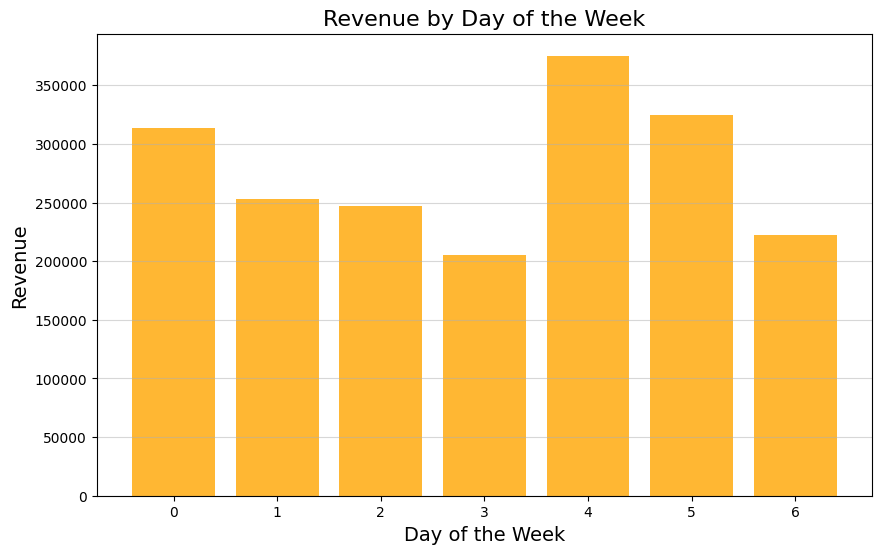

In [ ]:

# Taking the dataset for the datafrane 'df'
# Grouping revenue by the day of the week
day_of_week_revenue = df.groupby('day_of_week')['revenue'].sum().reset_index()

# Plotting the bar chart
plt.figure (figsize=(10, 6))
plt.bar (day_of_week_revenue['day_of_week'] , day_of_week_revenue['revenue'], color='orange', alpha=0.8)
plt.title ('Revenue by Day of the Week', fontsize=16)
plt.xlabel ('Day of the Week', fontsize=14)
plt.ylabel ('Revenue', fontsize=14)
plt.xticks (day_of_week_revenue['day_of_week'])  # Adjust tick labels
plt.grid ( axis='y', alpha=0.5 )
plt.show()

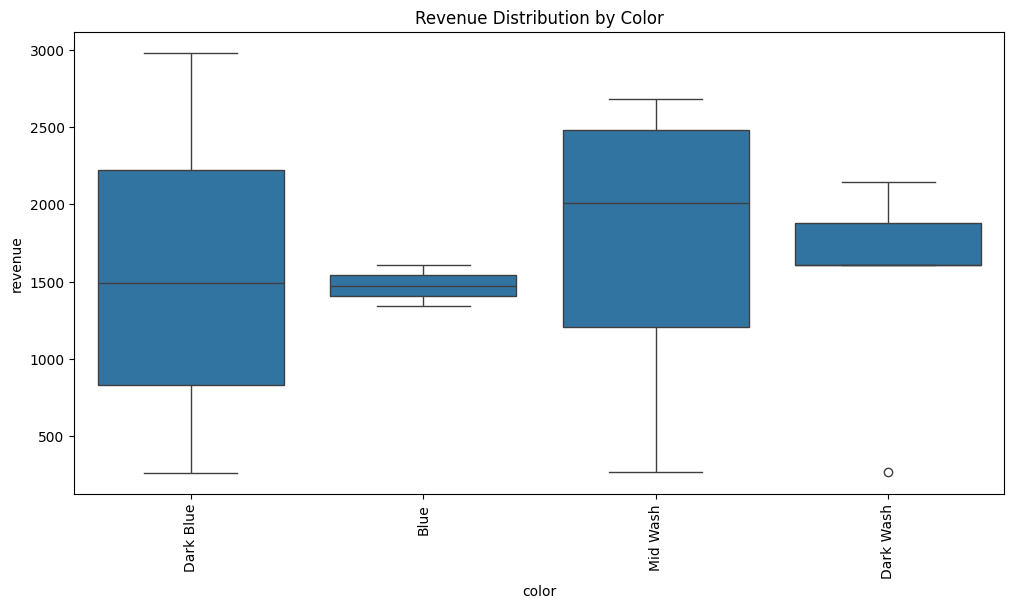

In [ ]:
# Box plot the distribution of revenue across different colors
plt.figure ( figsize=(12, 6))
sns.boxplot ( data=df, x='color', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ( 'Revenue Distribution by Color')
plt.show()

In [ ]:
color_revenue_avg = df.groupby('color')['revenue'].mean().reset_index()

# Displaying  the average revenue by color
print(color_revenue_avg)

       color      revenue
0       Blue  1474.000000
1  Dark Blue  1531.905675
2  Dark Wash  1500.800000
3   Mid Wash  1775.500000


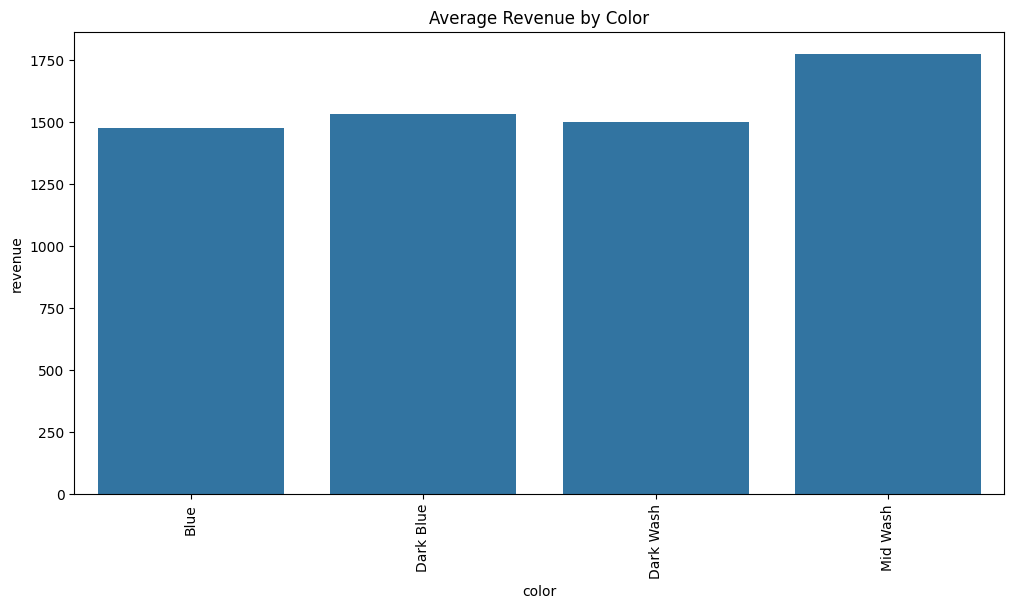

In [ ]:
# Using Bar plot for the average revenue by color
plt.figure (figsize=(12, 6))
sns.barplot ( data=color_revenue_avg, x='color', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ('Average Revenue by Color')
plt.show()

In [ ]:
from scipy.stats import f_oneway

# Performing the ANOVA to test if the revenue differs by color
colors = df['color'].unique()
grouped_revenue = [df[df['color'] == color]['revenue'] for color in colors]
anova_result = f_oneway(*grouped_revenue)

# Displaying the result of the ANOVA test
print ("ANOVA test result:", anova_result)

ANOVA test result: F_onewayResult(statistic=np.float64(0.2453618213570647), pvalue=np.float64(0.8646670190486041))


In [ ]:
# Perfoming it to get check the variance difference between revenue and color
model = smf.ols('revenue ~ C(color)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['revenue'], groups=df['color'], alpha=0.05)
print(tukey)

                sum_sq      df         F    PR(>F)
C(color)  4.840270e+05     3.0  0.245362  0.864667
Residual  8.298521e+08  1262.0       NaN       NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2  meandiff p-adj    lower      upper   reject
---------------------------------------------------------------
     Blue Dark Blue  57.9057 0.9996 -1418.3132 1534.1246  False
     Blue Dark Wash     26.8    1.0 -1718.4912 1772.0912  False
     Blue  Mid Wash    301.5 0.9656 -1347.6452 1950.6452  False
Dark Blue Dark Wash -31.1057 0.9998  -965.8655  903.6542  False
Dark Blue  Mid Wash 243.5943 0.8319  -496.2802  983.4689  False
Dark Wash  Mid Wash    274.7 0.9338  -914.5155 1463.9155  False
---------------------------------------------------------------


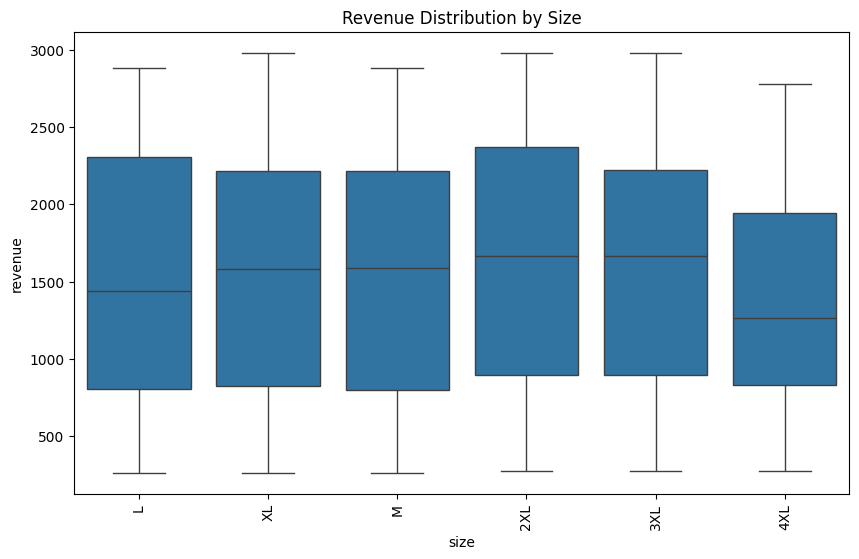

In [ ]:
# Box plot for visualizing the distribution of revenue across different sizes
plt.figure ( figsize=(10, 6))
sns.boxplot ( data=df, x='size', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ('Revenue Distribution by Size')
plt.show()

In [ ]:
# Calculating the average revenue per size
size_revenue_avg = df.groupby('size')['revenue'].mean().reset_index()

# Displaying the average revenue by size
print (size_revenue_avg)

  size      revenue
0  2XL  1606.991597
1  3XL  1597.295652
2  4XL  1303.200000
3    L  1528.045455
4    M  1534.228782
5   XL  1515.788009


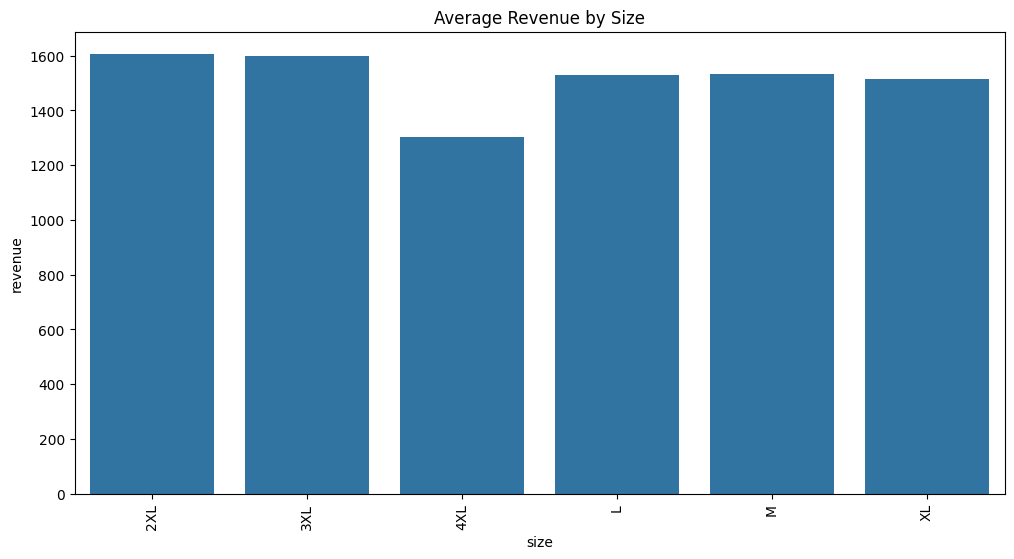

In [ ]:
# Bar plot for average revenue by size
plt.figure (figsize=(12, 6))
sns.barplot (data=size_revenue_avg, x='size', y='revenue')
plt.xticks ( rotation=90)  # Rotate the x-axis labels for better visibility
plt.title ( 'Average Revenue by Size')
plt.show()

In [ ]:
# Performing the ANOVA to test if the revenue differs by size
sizes = df['size'].unique()
grouped_revenue = [df[df['size'] == size]['revenue'] for size in sizes]
anova_result = f_oneway(*grouped_revenue)

# Display the result of the ANOVA test
print("ANOVA test result:", anova_result)

ANOVA test result: F_onewayResult(statistic=np.float64(0.8698587424189351), pvalue=np.float64(0.5006156143720963))


<ipython-input-198-0d141e04e4b7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot (x=size_revenue_avg['size'], y=size_revenue_avg['revenue'], palette="viridis")


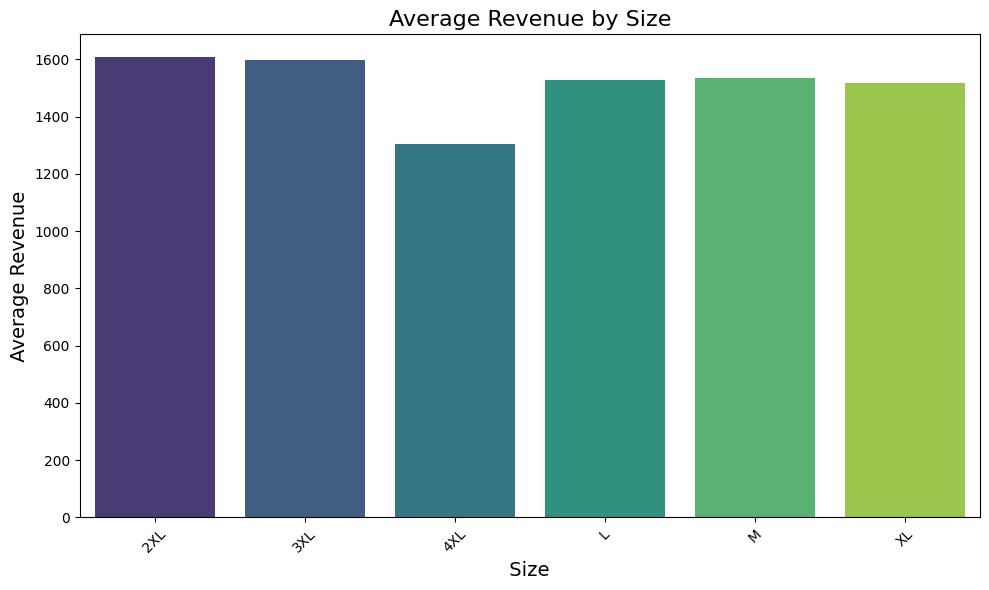

revenue     1.000000
size_3XL    0.025005
size_M      0.000643
size_L     -0.003286
size_XL    -0.016466
size_4XL   -0.044251
Name: revenue, dtype: float64


In [ ]:
# Visualization: Bar plot of revenue by size
plt.figure ( figsize=(10, 6))
# Using the size average mean
sns.barplot (x=size_revenue_avg['size'], y=size_revenue_avg['revenue'], palette="viridis")
plt.title ( 'Average Revenue by Size', fontsize=16)
plt.xlabel ( ' Size ', fontsize=14 )
plt.ylabel (' Average Revenue ' , fontsize=14)
plt.xticks ( rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis (one-hot encode size to compute Pearson correlation)
size_encoded =  pd.get_dummies (df['size'], prefix='size', drop_first=True)
size_encoded['revenue'] =  df['revenue']
correlation_with_revenue =  size_encoded.corr()['revenue'].sort_values(ascending=False)

print(correlation_with_revenue)

<ipython-input-199-50b3d2e2f769>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot (x=color_revenue_avg['color'], y=color_revenue_avg['revenue'], palette="viridis")


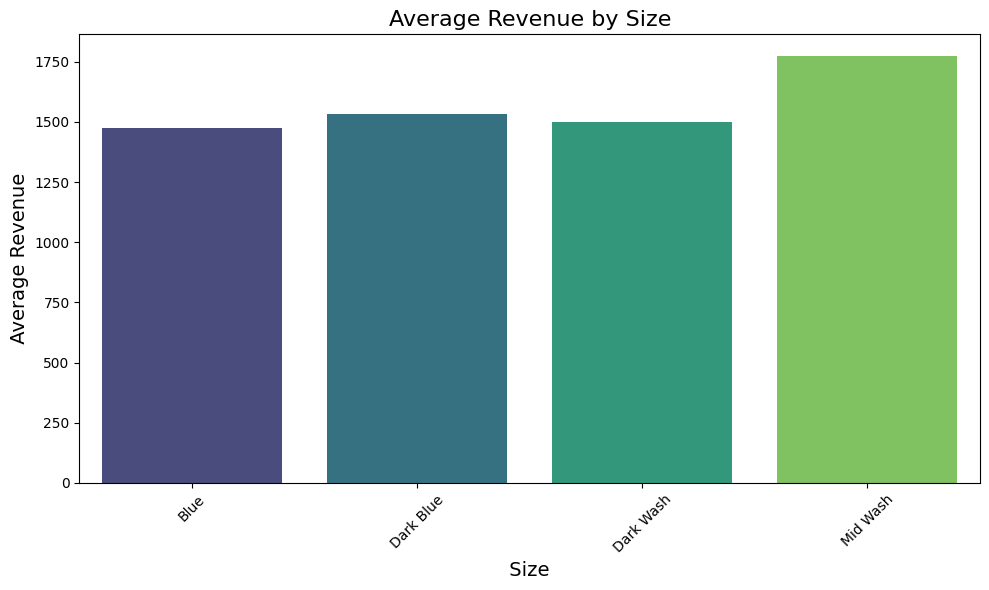

revenue            1.000000
color_Mid Wash     0.023856
color_Dark Wash   -0.002522
color_Dark Blue   -0.014941
Name: revenue, dtype: float64


In [ ]:
# Visualization: Bar plot of revenue by color
plt.figure ( figsize=(10, 6))
# Using the color average mean
sns.barplot (x=color_revenue_avg['color'], y=color_revenue_avg['revenue'], palette="viridis")
plt.title ( 'Average Revenue by Size', fontsize=16)
plt.xlabel ( ' Size ', fontsize=14 )
plt.ylabel (' Average Revenue ' , fontsize=14)
plt.xticks ( rotation=45)
plt.tight_layout()
plt.show()

# Correlation analysis (one-hot encode color to compute Pearson correlation)
color_encoded =  pd.get_dummies (df['color'], prefix='color', drop_first=True)
color_encoded['revenue'] =  df['revenue']
correlation_with_revenue =  color_encoded.corr()['revenue'].sort_values(ascending=False)

print(correlation_with_revenue)

In [ ]:
# Perfoming Tukey's HSD to check the significance in between revenue and size
model = smf.ols('revenue ~ C(size)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(endog=df['revenue'], groups=df['size'], alpha=0.05)
print(tukey)

                sum_sq      df         F    PR(>F)
C(size)   2.856312e+06     5.0  0.869859  0.500616
Residual  8.274798e+08  1260.0       NaN       NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
   2XL    3XL   -9.6959    1.0 -312.1426 292.7507  False
   2XL    4XL -303.7916 0.4435 -776.3139 168.7307  False
   2XL      L  -78.9461 0.9508 -334.3263 176.4341  False
   2XL      M  -72.7628 0.9646 -327.1162 181.5905  False
   2XL     XL  -91.2036 0.8831 -328.7126 146.3055  False
   3XL    4XL -294.0957 0.4855 -768.2697 180.0783  False
   3XL      L  -69.2502 0.9733 -327.6737 189.1733  False
   3XL      M  -63.0669  0.982 -320.4757 194.3419  False
   3XL     XL  -81.5076 0.9285  -322.286 159.2707  False
   4XL      L  224.8455 0.7024 -220.7845 670.4754  False
   4XL      M  231.0288 0.6762 -214.0135 676.0711  False
   4XL     XL   212.588 0.7315 -223.0466 648.2227

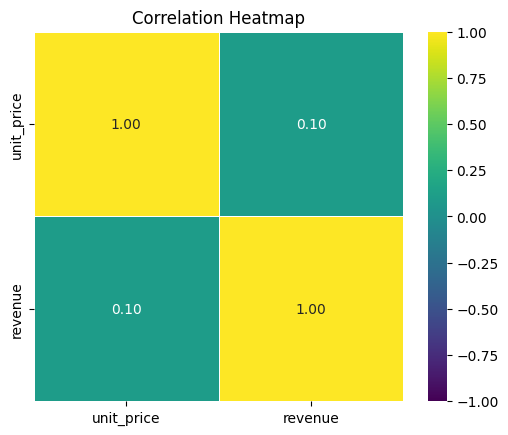

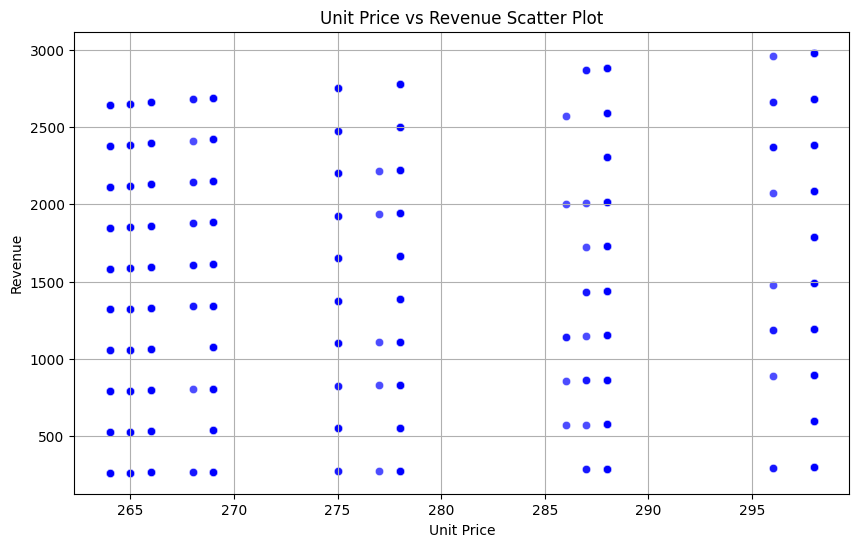

In [ ]:
# Finding the correlation between unit_price and revenue
correlation_matrix = df[['unit_price', 'revenue']].corr()

#using heatmaps
sns.heatmap(correlation_matrix, cmap = 'viridis', vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


#Scatter plot for unit_price vs revenue
plt.figure (figsize=(10, 6))
sns.scatterplot (data=df, x='unit_price', y='revenue', color='blue', alpha=0.7)
plt.title ("Unit Price vs Revenue Scatter Plot")
plt.xlabel ("Unit Price")
plt.ylabel ("Revenue")
plt.grid (True)
plt.show()

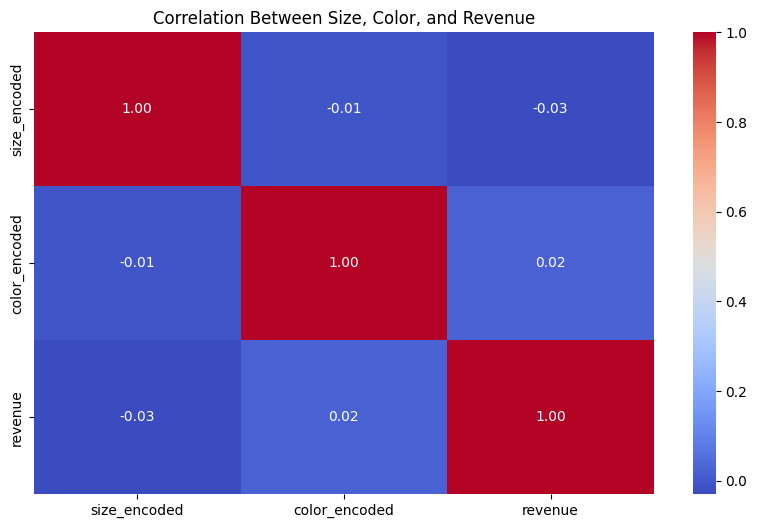

In [ ]:
df['size_encoded'] = df['size'].astype('category').cat.codes
df['color_encoded'] = df['color'].astype('category').cat.codes

# Correlation between size, color, and revenue
size_color_revenue_correlation = df[['size_encoded', 'color_encoded', 'revenue']].corr()

# Visualizing the correlation using a heatmap
plt.figure (figsize=(10,6))
sns.heatmap (size_color_revenue_correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title ("Correlation Between Size, Color, and Revenue")
plt.show()



   order_id  revenue  quantity  unit_price          order_date  \
0         1     9834        33  298.000000 2022-06-01 16:05:00   
1         3    14704        54  272.400000 2022-06-10 19:59:00   
2         4    11744        43  272.000000 2022-06-11 11:42:00   
3         5    17052        63  270.222222 2022-06-11 14:46:00   
4         6     5838        21  278.000000 2022-08-31 15:28:00   

   avg_revenue_per_item  
0            298.000000  
1            272.296296  
2            273.116279  
3            270.666667  
4            278.000000  


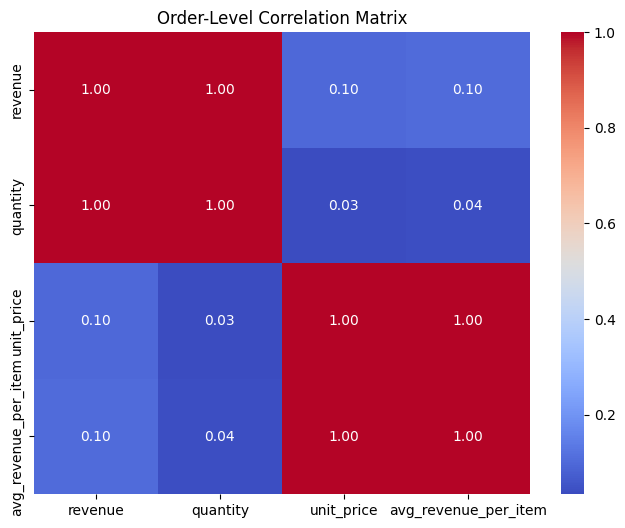

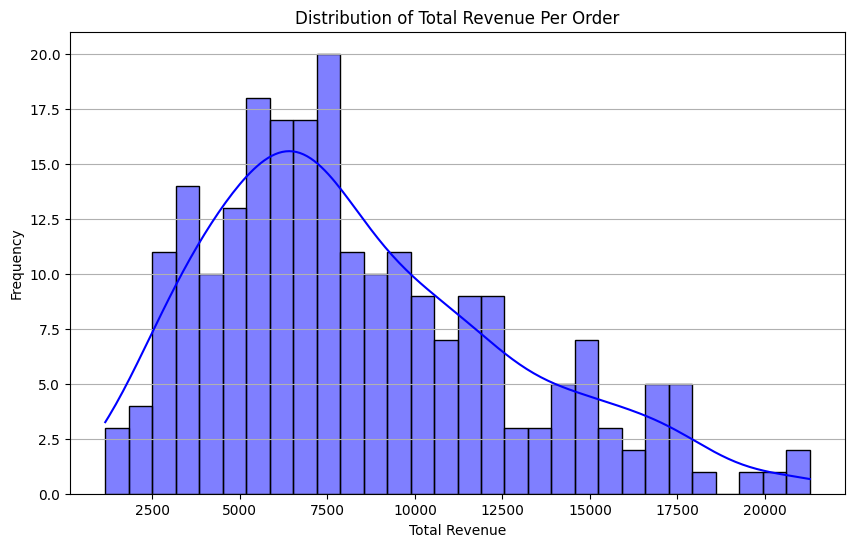

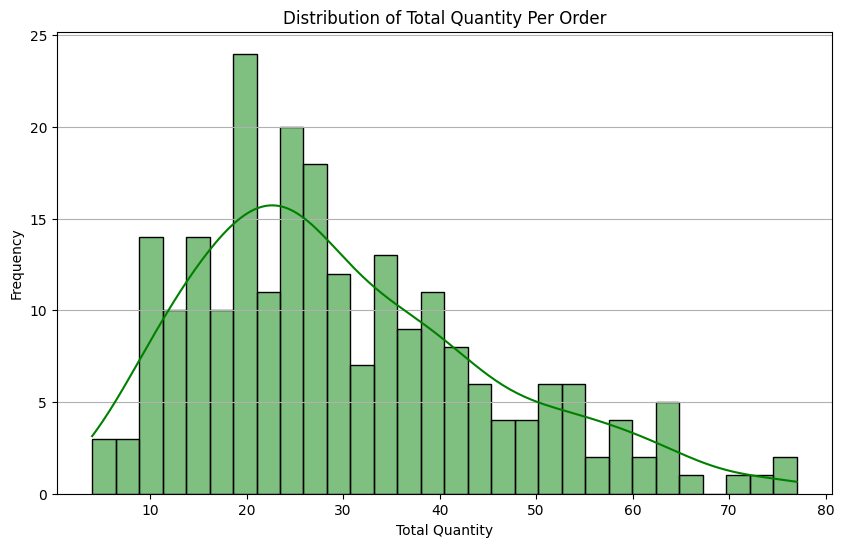

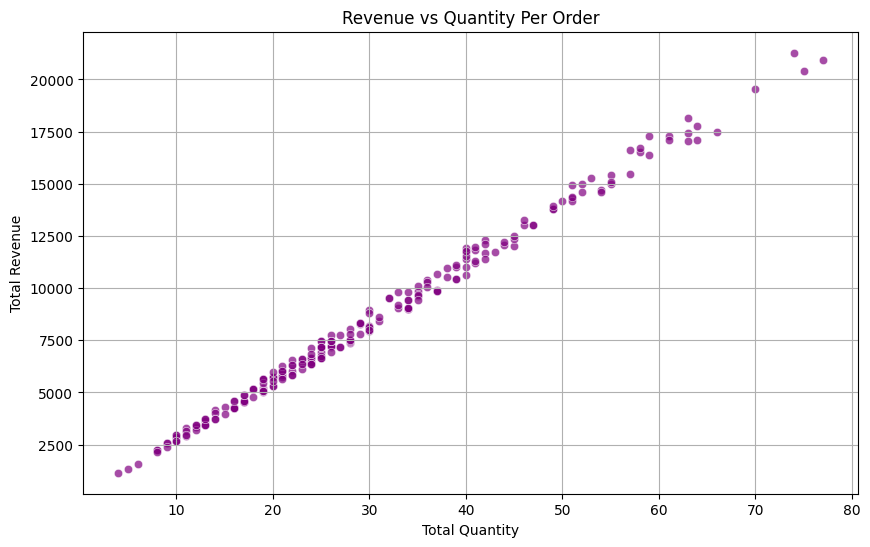

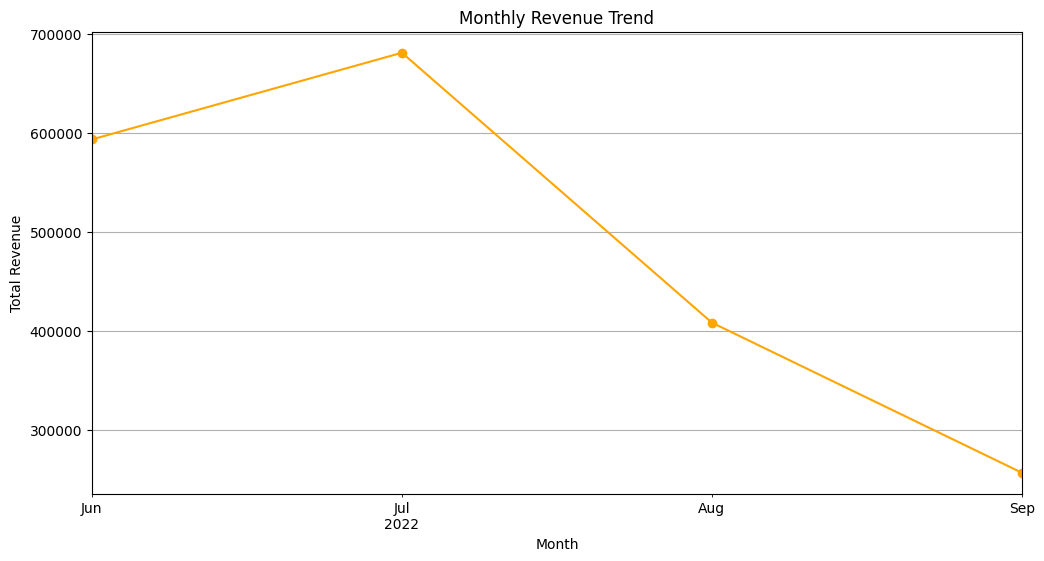

In [ ]:
# 1. Aggregating data at the order level
order_data = df.groupby('order_id').agg({
    'revenue': 'sum',               # Total revenue per order
    'quantity': 'sum',              # Total quantity per order
    'unit_price': 'mean',           # Average unit price per order
    'order_date': 'min'             # Order date (assuming one date per order_id)
}).reset_index()

# Adding  additional metrics like average revenue per item
# Removing extra spaces around the column name
order_data['avg_revenue_per_item'] = order_data['revenue'] / order_data['quantity']

# Displaying  the aggregated order-level data
print (order_data.head())

# 2. Correlation analysis at the order level
# Removing extra spaces around the column name
order_level_correlation  = order_data [['revenue', 'quantity', 'unit_price', 'avg_revenue_per_item']].corr()

# Visualize correlation matrix
plt.figure (figsize = (8, 6) )
sns.heatmap (order_level_correlation, annot=True, cmap='coolwarm', fmt=".2f" )
plt.title ( "Order-Level Correlation Matrix")
plt.show()
# 3. Revenue distribution across orders
plt.figure(figsize = ( 10, 6))
sns.histplot (order_data ['revenue'], bins=30, kde=True, color='blue' )
plt.title ("Distribution of Total Revenue Per Order")
plt.xlabel ("Total Revenue")
plt.ylabel ("Frequency")
plt.grid (axis='y')
plt.show()

# 4. Quantity distribution across orders
plt.figure (figsize = (10, 6))
sns.histplot ( order_data ['quantity'], bins=30 , kde=True, color='green')
plt.title ("Distribution of Total Quantity Per Order")
plt.xlabel ("Total Quantity")
plt.ylabel ("Frequency")
plt.grid (axis='y')
plt.show()

# 5. Analyze revenue vs quantity at the order level
plt.figure(figsize = (10, 6))
sns.scatterplot (data=order_data, x ='quantity', y='revenue', alpha=0.7, color='purple')
plt.title ("Revenue vs Quantity Per Order")
plt.xlabel ("Total Quantity")
plt.ylabel ("Total Revenue")
plt.grid()
plt.show()

# 6. Time-series analysis (if order_date is available)
if 'order_date' in order_data.columns:
    order_data['month'] =order_data['order_date'].dt.to_period('M')
    monthly_revenue =order_data.groupby ('month')['revenue'].sum()
# Plot monthly revenue trend
plt.figure (figsize=(12, 6))
monthly_revenue.plot (kind='line', marker='o', color='orange', title="Monthly Revenue Trend")
plt.xlabel ("Month")
plt.ylabel ("Total Revenue")
plt.grid()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Dividing the data into weekdays and weekends
weekends =  df[df['day_of_week'].isin([5, 6])]['revenue']  # Saturday=5, Sunday=6
weekdays =  df[~df['day_of_week'].isin([5, 6])]['revenue']

# Perform the T-test
t_stat, p_value = ttest_ind(weekends, weekdays)
print ( f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Revenue is significantly higher on weekends.")
else:
    print("Fail to reject the null hypothesis: No significant difference in revenue.")

T-Statistic: -0.3601496792498661, P-Value: 0.718795371705832
Fail to reject the null hypothesis: No significant difference in revenue.


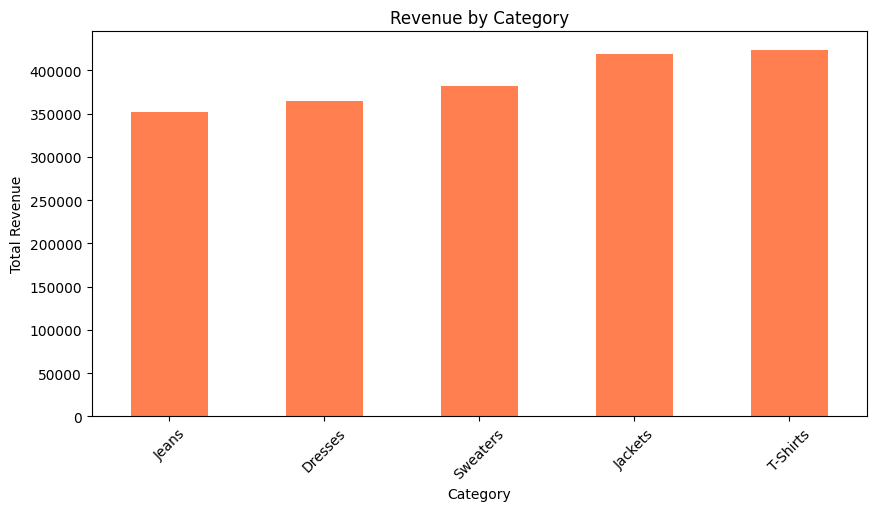

In [ ]:
# Group by Category and sum revenue
category_revenue = df.groupby("category")["revenue"].sum().sort_values()

# Bar plot
plt.figure(figsize=(10,5))
category_revenue.plot(kind='bar', color='coral')
plt.xlabel("Category")
plt.ylabel("Total Revenue")
plt.title("Revenue by Category")
plt.xticks(rotation=45)
plt.show()


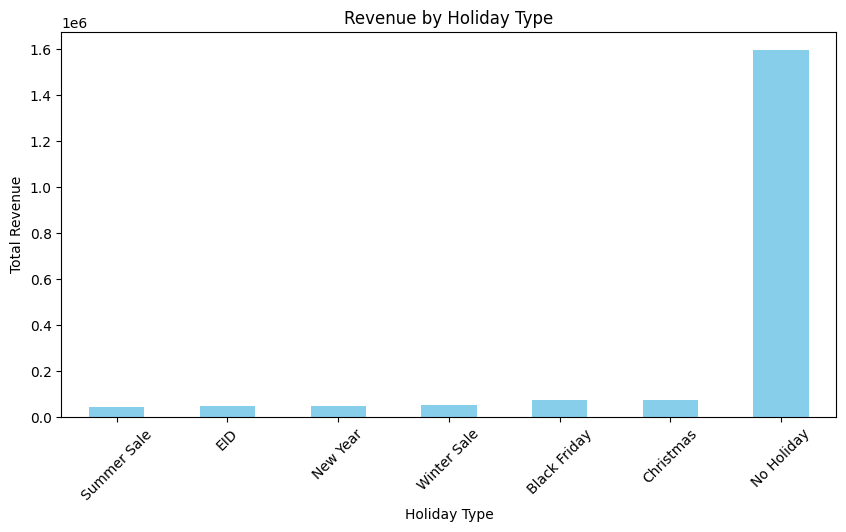

In [ ]:

# Group by Holiday Type and sum revenue
holiday_revenue = df.groupby("holiday_type")["revenue"].sum().sort_values()

# Bar plot
plt.figure(figsize=(10,5))
holiday_revenue.plot(kind='bar', color='skyblue')
plt.xlabel("Holiday Type")
plt.ylabel("Total Revenue")
plt.title("Revenue by Holiday Type")
plt.xticks(rotation=45)
plt.show()


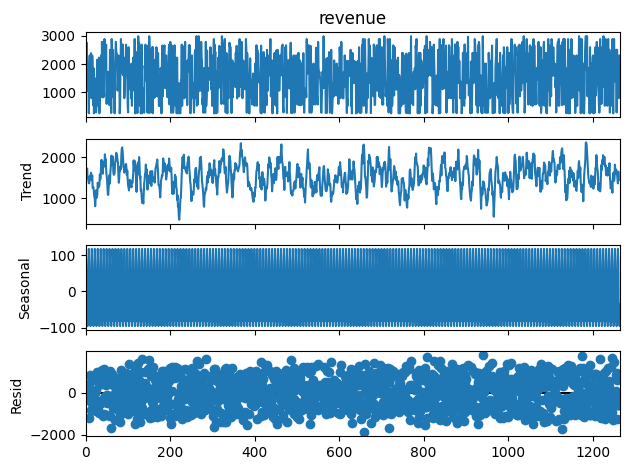

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming the data has a daily frequency, set the period accordingly
# Period value will be adjusted according the dataset
result = seasonal_decompose(df['revenue'], model='additive', period=7)  # Assuming weekly seasonality

result.plot()
plt.show()


# Model Traning with Linear Regression:

In [ ]:
# Convert Date column to datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Extract useful date-based features
df['Year'] = df['order_date'].dt.year
df['Month'] = df['order_date'].dt.month
df['Day'] = df['order_date'].dt.day
df['DayOfWeek'] = df['order_date'].dt.dayofweek
df['WeekOfYear'] = df['order_date'].dt.isocalendar().week

# Drop the original datetime column
df.drop(columns=['order_date'], inplace=True)


In [ ]:
# Selecting categorical columns
categorical_cols = ['category', 'color', 'size', 'holiday_type']  # Add any other categorical features

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Splitting into features and target variable
X = df_encoded.drop(columns=['revenue'])
y = df_encoded['revenue']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Print model coefficients
print("Model coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Model coefficients: [ 2.13813168e-02  1.62899249e-02  5.49964078e+00  2.79149688e+02
  7.40926756e-02 -5.46466431e-02  7.51843989e-01  7.26833814e-03
 -6.05284300e-01  1.25007339e-01  7.53578264e-05 -3.42542178e-01
 -8.66862138e-13 -2.71228091e+01  7.46117128e-01 -9.08968221e-01
  6.68798350e-13 -3.41305800e-01 -7.14290029e+00 -1.13686838e-13
 -2.71228091e+01 -9.08968221e-01  7.46117128e-01  1.20576022e+01
 -3.34054685e-02 -7.06423961e-01  1.98320035e-01  9.53778988e-03
  5.90412528e+00  1.04269002e+01 -1.13002753e+01  3.26645961e-01
  2.85887224e+00 -1.71897944e+00  1.34172911e+00 -1.31913487e+00
 -5.52118308e+00  4.97712724e+00  1.94084003e+00  2.17969454e+00
 -1.13119355e+00  1.72309352e+00]
Intercept: -1539.0527285322682


In [ ]:
feature_names = X_train.columns  # Get feature names
coefficients = model.coef_  # Get coefficients

for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef:.4f}")


order_id: 0.0214
sku: 0.0163
unit_price: 5.4996
quantity: 279.1497
age: 0.0741
discount: -0.0546
customer_rating: 0.7518
stock: 0.0073
category_id: -0.6053
category_avg_price: 0.1250
category_total_revenue: 0.0001
category_popularity: -0.3425
year: -0.0000
month: -27.1228
day_of_week: 0.7461
day: -0.9090
is_holiday: 0.0000
size_encoded: -0.3413
color_encoded: -7.1429
Year: -0.0000
Month: -27.1228
Day: -0.9090
DayOfWeek: 0.7461
WeekOfYear: 12.0576
category_Jackets: -0.0334
category_Jeans: -0.7064
category_Sweaters: 0.1983
category_T-Shirts: 0.0095
color_Dark Blue: 5.9041
color_Dark Wash: 10.4269
color_Mid Wash: -11.3003
size_3XL: 0.3266
size_4XL: 2.8589
size_L: -1.7190
size_M: 1.3417
size_XL: -1.3191
holiday_type_Christmas: -5.5212
holiday_type_EID: 4.9771
holiday_type_New Year: 1.9408
holiday_type_No Holiday: 2.1797
holiday_type_Summer Sale: -1.1312
holiday_type_Winter Sale: 1.7231


In [ ]:
print(X_test.dtypes)

order_id                     int64
sku                          int64
unit_price                   int64
quantity                     int64
age                          int64
discount                     int64
customer_rating              int64
stock                        int64
category_id                  int64
category_avg_price           int64
category_total_revenue       int64
category_popularity          int64
year                         int32
month                        int32
day_of_week                  int32
day                          int32
is_holiday                    bool
size_encoded                  int8
color_encoded                 int8
Year                         int32
Month                        int32
Day                          int32
DayOfWeek                    int32
WeekOfYear                  UInt32
category_Jackets              bool
category_Jeans                bool
category_Sweaters             bool
category_T-Shirts             bool
color_Dark Blue     

In [ ]:
from sklearn.metrics import mean_absolute_error

X_train = X_train.drop(columns=['sku', 'order_id'], errors='ignore')
X_test = X_test.drop(columns=['sku', 'order_id'], errors='ignore')
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 27.646398804211877
MSE: 1196.0382889274624
R² Score: 0.9980679971942261


# Model training with LightGBM

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[777]	valid's l1: 2.18449
✅ LightGBM - MAE: 2.1845
✅ LightGBM - MSE: 17.9913
✅ LightGBM - R² Score: 0.999971


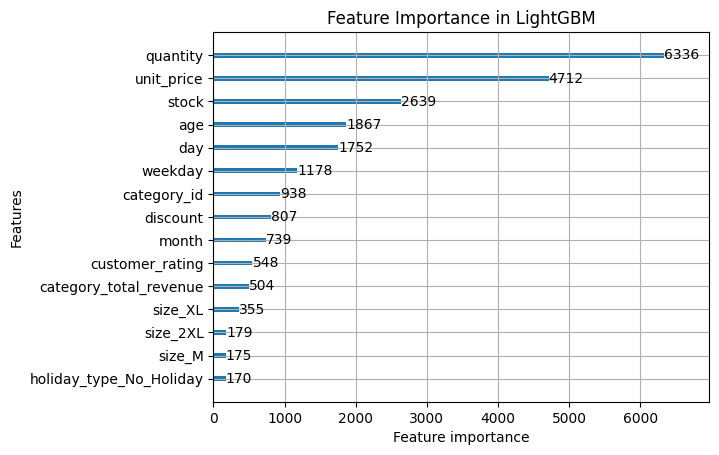

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 🔹 Load dataset
file_path = "/content/Women_Ecommerce_Purchase_Data.csv"
df = pd.read_csv(file_path)

# 🔹 Drop unnecessary columns (order_id and sku are identifiers, not useful for training)
df = df.drop(columns=['order_id', 'sku'])

# 🔹 Convert 'order_date' to datetime and extract useful features
df['order_date'] = pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['weekday'] = df['order_date'].dt.weekday  # Monday = 0, Sunday = 6
df = df.drop(columns=['order_date'])  # Remove raw date column

# 🔹 Convert categorical variables using one-hot encoding
categorical_columns = ['color', 'size', 'category', 'holiday_type']
df = pd.get_dummies(df, columns=categorical_columns)

# 🔹 Define target variable and features
X = df.drop(columns=['revenue'])  # Features
y = df['revenue']  # Target

# 🔹 Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Create LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 🔹 Define LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1
}

# 🔹 Train LightGBM Model with early stopping
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    valid_names=['valid'],
    callbacks=[lgb.early_stopping(50)]
)

# 🔹 Make predictions
y_pred = model.predict(X_test)

# 🔹 Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ LightGBM - MAE: {mae:.4f}")
print(f"✅ LightGBM - MSE: {mse:.4f}")
print(f"✅ LightGBM - R² Score: {r2:.6f}")

# 🔹 Feature Importance
lgb.plot_importance(model, max_num_features=15)
plt.title("Feature Importance in LightGBM")
plt.show()



In [ ]:
X.columns = X.columns.str.replace(" ", "_")  # Replace spaces with underscores
# Replace spaces in column names to avoid LightGBM warnings
X.columns = X.columns.str.replace(" ", "_", regex=True)


# Selected Model Evaluation (LightGBM in this case)

In [ ]:
!pip install optuna

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "verbosity": -1,  # Suppresses logs
    }

    # Create LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[test_data],  # Validation set
        valid_names=["valid"],
        callbacks=[lgb.log_evaluation(0)] # Remove this line if error persists
    )

    # Make predictions
    y_pred = model.predict(X_test)

    # Return MAE (Optuna minimizes this)
    return mean_absolute_error(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)



[I 2025-04-10 17:48:36,566] A new study created in memory with name: no-name-4d75c958-89dd-4ac5-8db7-872159944aed
[I 2025-04-10 17:48:37,587] Trial 0 finished with value: 72.48488688754338 and parameters: {'learning_rate': 0.0055678258192772435, 'num_leaves': 270, 'min_data_in_leaf': 173, 'max_depth': 9, 'feature_fraction': 0.5418484178826779, 'bagging_fraction': 0.9098030487556541, 'bagging_freq': 7, 'lambda_l1': 0.0529043178535373, 'lambda_l2': 3.037017732914726e-07}. Best is trial 0 with value: 72.48488688754338.
[I 2025-04-10 17:48:39,386] Trial 1 finished with value: 14.260017329256863 and parameters: {'learning_rate': 0.01540713452132887, 'num_leaves': 223, 'min_data_in_leaf': 37, 'max_depth': 10, 'feature_fraction': 0.6746384410717521, 'bagging_fraction': 0.7849126668396726, 'bagging_freq': 9, 'lambda_l1': 0.006863090274226622, 'lambda_l2': 4.073203271891766}. Best is trial 1 with value: 14.260017329256863.
[I 2025-04-10 17:48:39,985] Trial 2 finished with value: 131.05851086872

Best Hyperparameters: {'learning_rate': 0.16511095881725937, 'num_leaves': 174, 'min_data_in_leaf': 44, 'max_depth': 9, 'feature_fraction': 0.9302201359746392, 'bagging_fraction': 0.7101463768028224, 'bagging_freq': 9, 'lambda_l1': 4.856713728173023e-05, 'lambda_l2': 0.024454533366037222}


[100]	valid's l1: 7.37273
[200]	valid's l1: 2.55045
[300]	valid's l1: 2.24837
[400]	valid's l1: 2.05189
[500]	valid's l1: 1.88939
[600]	valid's l1: 1.79338
[700]	valid's l1: 1.72632
[800]	valid's l1: 1.65958
[900]	valid's l1: 1.60705
[1000]	valid's l1: 1.56774
✅ LightGBM - MAE: 1.5677
✅ LightGBM - MSE: 6.0512
✅ LightGBM - R² Score: 0.999990


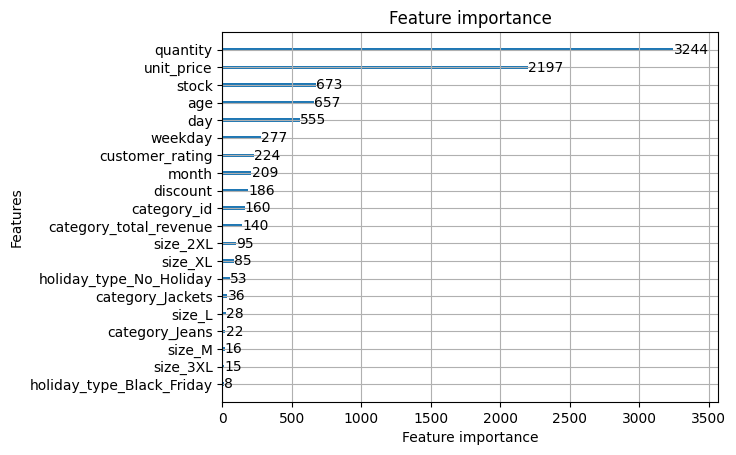

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load dataset (Assume df is already loaded)
# Ensure column names are correct
df.rename(columns={'y': 'revenue'}, inplace=True)

# Handle categorical features
categorical_features = ['size', 'category', 'holiday_type']

# Define input (X) and target variable (y)
X = df.drop(columns=['revenue'])  # Revenue is the target
y = df['revenue']

# Split into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure same features in training and validation sets
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_valid.fillna(0, inplace=True)  # Fill missing values if necessary

# Best LightGBM parameters (based on your previous tuning)
best_params = {
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "learning_rate": 0.048052360116289175,
    "num_leaves": 207,
    "min_data_in_leaf": 28,
    "max_depth": 4,
    "feature_fraction": 0.9816,
    "bagging_fraction": 0.8945,
    "bagging_freq": 5,
    "lambda_l1": 0.034,
    "lambda_l2": 0.1,
    "verbosity": -1
}

# Convert data into LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# Train the LightGBM model
final_model = lgb.train(
    best_params,
    train_data,
    num_boost_round=1000,
    valid_sets=[valid_data],
    valid_names=["valid"],
    callbacks=[lgb.log_evaluation(100)]  # Log every 100 rounds
)

# Make final predictions
y_pred = final_model.predict(X_valid)

# 🔹 Evaluate model
mae = mean_absolute_error(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print(f"✅ LightGBM - MAE: {mae:.4f}")
print(f"✅ LightGBM - MSE: {mse:.4f}")
print(f"✅ LightGBM - R² Score: {r2:.6f}")

lgb.plot_importance(final_model, max_num_features=20)
plt.show()


In [ ]:
final_model.save_model("lightgbm_model.txt")


In [ ]:
# The model is trained now, only thing to do is just load the model and give new dataset as its input

loaded_model = lgb.Booster(model_file="lightgbm_model.txt")
y_pred = loaded_model.predict(X_test)


# Prophet Model


In [ ]:
from prophet import Prophet
import pandas as pd

# Load dataset (ensure your dataset has 'ds' and 'y' columns)
df = pd.read_csv("/content/Women_Ecommerce_Purchase_Data.csv")
df=df.rename(columns={'order_date':'ds','revenue':'y'})

# Ensure the date column is in the correct format
df['ds'] = pd.to_datetime(df['ds'])

# Initialize and fit Prophet model
prophet = Prophet()
prophet.fit(df[['ds', 'y']])  # 'y' should be the column representing sales/revenue

# Create a future dataframe for forecasting
future = prophet.make_future_dataframe(periods=30)  # Change periods as needed

# Get forecast
forecast = prophet.predict(future)

# Extract the relevant prediction values
forecast = forecast[['ds', 'yhat']]

# Rename yhat (forecasted values) for merging with LightGBM dataset
forecast.rename(columns={'yhat': 'prophet_forecast'}, inplace=True)

# Merge Prophet results with your dataset (on date column)
df = df.merge(forecast, on='ds', how='left')

# Save the new dataset with Prophet results
df.to_csv("dataset_with_prophet.csv", index=False)

print("Prophet results added to dataset.")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxhghz4bd/qyssxhl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxhghz4bd/xhg3oexp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61901', 'data', 'file=/tmp/tmpxhghz4bd/qyssxhl5.json', 'init=/tmp/tmpxhghz4bd/xhg3oexp.json', 'output', 'file=/tmp/tmpxhghz4bd/prophet_modelokuipx3v/prophet_model-20250410174941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet results added to dataset.


# Testing the Model

In [ ]:
new_data=pd.read_csv("/content/SuperStoreOrders.csv")
new_data.head()

,order_id,order_date,ship_date,ship_mode,customer_name,segment,state,country,market,region,...,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority,year
0,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,Toby Braunhardt,Consumer,Constantine,Algeria,Africa,Africa,...,Office Supplies,Storage,"Tenex Lockers, Blue",408,2,0.0,106.140,35.46,Medium,2011
1,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Office Supplies,Supplies,"Acme Trimmer, High Speed",120,3,0.1,36.036,9.72,Medium,2011
2,HU-2011-1220,1/1/2011,5/1/2011,Second Class,Annie Thurman,Consumer,Budapest,Hungary,EMEA,EMEA,...,Office Supplies,Storage,"Tenex Box, Single Width",66,4,0.0,29.640,8.17,High,2011
3,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,Eugene Moren,Home Office,Stockholm,Sweden,EU,North,...,Office Supplies,Paper,"Enermax Note Cards, Premium",45,3,0.5,-26.055,4.82,High,2011
4,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,Joseph Holt,Consumer,New South Wales,Australia,APAC,Oceania,...,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",114,5,0.1,37.770,4.70,Medium,2011


In [ ]:
# Checking the missing values
print("Missing values per column:\n", new_data.isnull().sum())

# Filling the missing numeric columns with their median
numeric_cols = new_data.select_dtypes(include=['float64', 'int64']).columns
new_data[numeric_cols] = new_data[numeric_cols].fillna(new_data[numeric_cols].median())

# Fill missing categorical columns with '3XL'

Missing values per column:
 order_id          0
order_date        0
ship_date         0
ship_mode         0
customer_name     0
segment           0
state             0
country           0
market            0
region            0
product_id        0
category          0
sub_category      0
product_name      0
sales             0
quantity          0
discount          0
profit            0
shipping_cost     0
order_priority    0
year              0
dtype: int64


In [ ]:
print(new_data.duplicated().sum())

0


In [ ]:
print(new_data["quantity"].isna().sum())  # Count missing values
print((new_data["quantity"] == 0).sum())  # Count zero values


0
0


In [ ]:
# Convert to numeric, forcing errors='coerce' to handle non-numeric values
new_data["sales"] = pd.to_numeric(new_data["sales"], errors="coerce")
new_data["quantity"] = pd.to_numeric(new_data["quantity"], errors="coerce")

# Replace NaN values with 0 in both columns
new_data["sales"].fillna(0, inplace=True)
new_data["quantity"].fillna(1, inplace=True)  # Replace NaN quantity with 1 to avoid division errors

# Replace 0 quantity with 1 to avoid division by zero
new_data["quantity"] = new_data["quantity"].replace(0, 1)

# Calculate unit price safely
new_data["unit_price"] = new_data["sales"] / new_data["quantity"]

# Verify the column is created
print(new_data[["sales", "quantity", "unit_price"]].head())


   sales  quantity  unit_price
0  408.0         2       204.0
1  120.0         3        40.0
2   66.0         4        16.5
3   45.0         3        15.0
4  114.0         5        22.8


<ipython-input-225-da548a75d783>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data["sales"].fillna(0, inplace=True)
<ipython-input-225-da548a75d783>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
new_data["unit_price"] = pd.to_numeric(new_data["unit_price"], errors="coerce")
new_data["quantity"] = pd.to_numeric(new_data["quantity"], errors="coerce")

new_data["revenue"] = new_data["unit_price"] * new_data["quantity"]

# Fill any missing values in revenue with 0
new_data["revenue"].fillna(0, inplace=True)



<ipython-input-226-91117fa15853>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data["revenue"].fillna(0, inplace=True)


In [ ]:
import numpy as np

# Assigning sizes based on categories
size_mapping = {
    "T-Shirts": ["S", "M", "L", "XL"],
    "Jeans": ["28", "30", "32", "34"],
    "Jackets": ["S", "M", "L", "XL"],
}

# Randomly assign sizes based on category
new_data["size"] = new_data["category"].apply(lambda x: np.random.choice(size_mapping.get(x, ["M"])))


In [ ]:
new_data["stock"] = new_data.groupby("product_id")["quantity"].transform(lambda x: x.max() * 2)


In [ ]:
new_data["customer_rating"] = np.round(np.random.uniform(3.5, 5.0, len(new_data)), 1)


In [ ]:
# Calculate total revenue per category
category_revenue = new_data.groupby("category")["sales"].sum().reset_index()

# Rename the column
category_revenue.rename(columns={"sales": "category_total_revenue"}, inplace=True)

# Merge it back into new_data
new_data = new_data.merge(category_revenue, on="category", how="left")

print("✅ category_total_revenue added!")


✅ category_total_revenue added!


In [ ]:
print(f"New dataset date range: {new_data['order_date'].min()} → {new_data['order_date'].max()}")



New dataset date range: 1/1/2011 → 9/9/2014


In [ ]:
from prophet import Prophet
# Convert order_date to datetime, automatically handling multiple formats
new_data["order_date"] = pd.to_datetime(new_data["order_date"], dayfirst=True, errors="coerce")

# Rename columns to match Prophet requirements
df_prophet = new_data[['order_date', 'revenue']].rename(columns={'order_date': 'ds', 'revenue': 'y'})

# Convert dates to datetime format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


In [ ]:
# Remove rows with NaT (unrecognized dates)
df_prophet = df_prophet.dropna(subset=['ds'])

# Now fit the model
model_prophet = Prophet()
model_prophet.fit(df_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxhghz4bd/tjhpz16x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxhghz4bd/5b7aracx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65677', 'data', 'file=/tmp/tmpxhghz4bd/tjhpz16x.json', 'init=/tmp/tmpxhghz4bd/5b7aracx.json', 'output', 'file=/tmp/tmpxhghz4bd/prophet_modeljm5ffu0w/prophet_model-20250410174951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:49:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
print(df_prophet.isna().sum())  # Check for missing values
print(df_prophet.head())  # Preview the dataset


ds    0
y     0
dtype: int64
          ds      y
0 2011-01-01  408.0
1 2011-01-01  120.0
2 2011-01-01   66.0
3 2011-01-01   45.0
4 2011-01-01  114.0


In [ ]:
from prophet import Prophet  # If 'ModuleNotFoundError' occurs, install it: pip install prophet

# Prepare data for Prophet
df_prophet = new_data[['order_date', 'revenue']].rename(columns={'order_date': 'ds', 'revenue': 'y'})

# Convert to datetime
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], errors="coerce")

# Drop NaN dates
df_prophet = df_prophet.dropna(subset=["ds"])

# Fill missing revenue values
df_prophet["y"].fillna(0, inplace=True)

# Initialize and fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df_prophet)

print("✅ Prophet model trained successfully!")


<ipython-input-235-e33ae8b65e00>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_prophet["y"].fillna(0, inplace=True)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxhghz4bd/nu_85pd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxhghz4bd/xz0wzh44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin',

✅ Prophet model trained successfully!


In [ ]:
# Convert order_date to datetime format
new_data["order_date"] = pd.to_datetime(new_data["order_date"], errors="coerce")

# Drop NaN values that couldn't be converted
new_data = new_data.dropna(subset=["order_date"])
print(future.isna().sum())  # Check if there are NaNs in ds
print(future.head())  # Preview future DataFrame


ds    0
dtype: int64
                   ds
0 2022-06-01 16:05:00
1 2022-06-02 12:57:00
2 2022-06-03 11:52:00
3 2022-06-06 00:06:00
4 2022-06-06 00:12:00


In [ ]:
# Create future dataframe with all order dates
future = pd.DataFrame({"ds": new_data["order_date"]})

# Make predictions
forecast = model_prophet.predict(future)

# Keep only the forecasted values
forecast = forecast[['ds', 'yhat']].rename(columns={'ds': 'order_date', 'yhat': 'prophet_forecast'})

# Merge forecast with new_data
new_data = new_data.merge(forecast, on="order_date", how="left")

print("✅ Prophet forecast successfully added to the new dataset!")


✅ Prophet forecast successfully added to the new dataset!


In [ ]:
if "prophet_forecast" in new_data.columns:
    print("🎉 Prophet forecast is ready! You can now use it in your model.")
else:
    print("⚠️ Prophet forecast is still missing!")


🎉 Prophet forecast is ready! You can now use it in your model.


In [ ]:
# Define the expected features
expected_features = [
    "size", "stock", "unit_price", "customer_rating", "discount",
    "category_total_revenue", "prophet_forecast"
]

# Add one-hot encoded color columns
color_features = [col for col in new_data.columns if col.startswith("color_")]
expected_features += color_features

# Check for missing features
missing_features = [col for col in expected_features if col not in new_data.columns]

if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    print("✅ All features are available!")


✅ All features are available!


In [ ]:

#Load the trained model
model = lgb.Booster(model_file="lightgbm_model.txt")  # Change to your saved model filename
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
# Define the features used in the model
#feature_columns = [col for col in new_data.columns if col != "revenue"]

# Select only these features
#X_new = new_data[feature_columns]

# Ensure feature order matches model training data
#X_new = X_new[model.feature_name()]


In [ ]:
import lightgbm as lgb

# Load the saved model
model = lgb.Booster(model_file="lightgbm_model.txt")

# Get feature names from the model
expected_features = model.feature_name()

print("Features used during training:", expected_features)


Features used during training: ['unit_price', 'quantity', 'age', 'discount', 'customer_rating', 'stock', 'category_id', 'category_avg_price', 'category_total_revenue', 'category_popularity', 'year', 'month', 'day', 'weekday', 'color_Blue', 'color_Dark_Blue', 'color_Dark_Wash', 'color_Mid_Wash', 'size_2XL', 'size_3XL', 'size_4XL', 'size_L', 'size_M', 'size_XL', 'category_Dresses', 'category_Jackets', 'category_Jeans', 'category_Sweaters', 'category_T-Shirts', 'holiday_type_Black_Friday', 'holiday_type_Christmas', 'holiday_type_EID', 'holiday_type_New_Year', 'holiday_type_No_Holiday', 'holiday_type_Summer_Sale', 'holiday_type_Winter_Sale']


In [ ]:
# List of categorical features that were used during training (excluding holiday_type)
categorical_features = ['size', 'category']

# One-hot encode the categorical features
new_data_encoded = pd.get_dummies(new_data, columns=categorical_features)

# Ensure all required features exist in new_data_encoded
for col in model.feature_name():
    if col not in new_data_encoded.columns:
        new_data_encoded[col] = 0  # Add missing features with 0

# Ensure the order of columns matches the model
X_new = new_data_encoded[model.feature_name()]


In [ ]:
# Get the list of features used in the trained model
expected_features = model.feature_name()

# Add missing columns that were in the original training data but not in new data
for col in expected_features:
    if col not in new_data.columns:
        new_data[col] = 0  # Set missing features to 0

# Ensure the order of columns matches what the model expects
X_new = new_data[expected_features]


In [ ]:
# Predict revenue using the trained model
new_data["predicted_revenue"] = model.predict(X_new)

print("✅ Predictions successfully made!")


✅ Predictions successfully made!


In [ ]:
new_data.to_csv("predicted_revenue.csv", index=False)
print("✅ Predictions saved to 'predicted_revenue.csv'!")


✅ Predictions saved to 'predicted_revenue.csv'!


In [ ]:

# Load the saved predictions
predicted_data = pd.read_csv("predicted_revenue.csv")

# Display some results
print(predicted_data[["order_date", "predicted_revenue"]].head())


   order_date  predicted_revenue
0  2011-01-01         527.861724
1  2011-01-01         527.861724
2  2011-01-01         527.861724
3  2011-01-01         527.861724
4  2011-01-01         527.861724


In [ ]:
import gradio as gr
import pandas as pd
import lightgbm as lgb
import numpy as np

# Load the LightGBM model (adjust the filename as needed)
model = lgb.Booster(model_file="lightgbm_model.txt")

# Define the prediction function
def predict_revenue(file):
    try:
        # Load CSV file
        df = pd.read_csv(file.name)

        # Check if required columns exist
        required_cols = ["unit_price", "quantity"]
        for col in required_cols:
            if col not in df.columns:
                return f"❌ Error: Missing required column: {col}"

        # Convert to numeric and drop rows with NaNs
        df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")
        df["quantity"] = pd.to_numeric(df["quantity"], errors="coerce")
        df.dropna(subset=["unit_price", "quantity"], inplace=True)

        # Prepare features for model
        X = df[["unit_price", "quantity"]]

        # Predict
        df["Predicted Revenue"] = model.predict(X)

        return df

    except Exception as e:
        return f"❌ Error occurred: {str(e)}"

# Create the Gradio interface
demo = gr.Interface(
    fn=predict_revenue,
    inputs=gr.File(label="📁 Upload your CSV file", file_types=[".csv"]),
    outputs=gr.Dataframe(label="📊 Predicted Results"),
    title="💡 Sales Revenue Prediction",
    description="Upload a cleaned CSV file with 'unit_price' and 'quantity' columns to get predictions."
)

# Launch the app
demo.launch()



Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0bd55af50e47196d70.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
